In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input


In [8]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Global Missing Migrants Dataset.csv'
data = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13020 entries, 0 to 13019
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Incident Type                        13020 non-null  object 
 1   Incident year                        13020 non-null  int64  
 2   Reported Month                       13020 non-null  object 
 3   Region of Origin                     12998 non-null  object 
 4   Region of Incident                   13020 non-null  object 
 5   Country of Origin                    13012 non-null  object 
 6   Number of Dead                       12470 non-null  float64
 7   Minimum Estimated Number of Missing  13020 non-null  int64  
 8   Total Number of Dead and Missing     13020 non-null  int64  
 9   Number of Survivors                  13020 non-null  int64  
 10  Number of Females                    13020 non-null  int64  
 11  Number

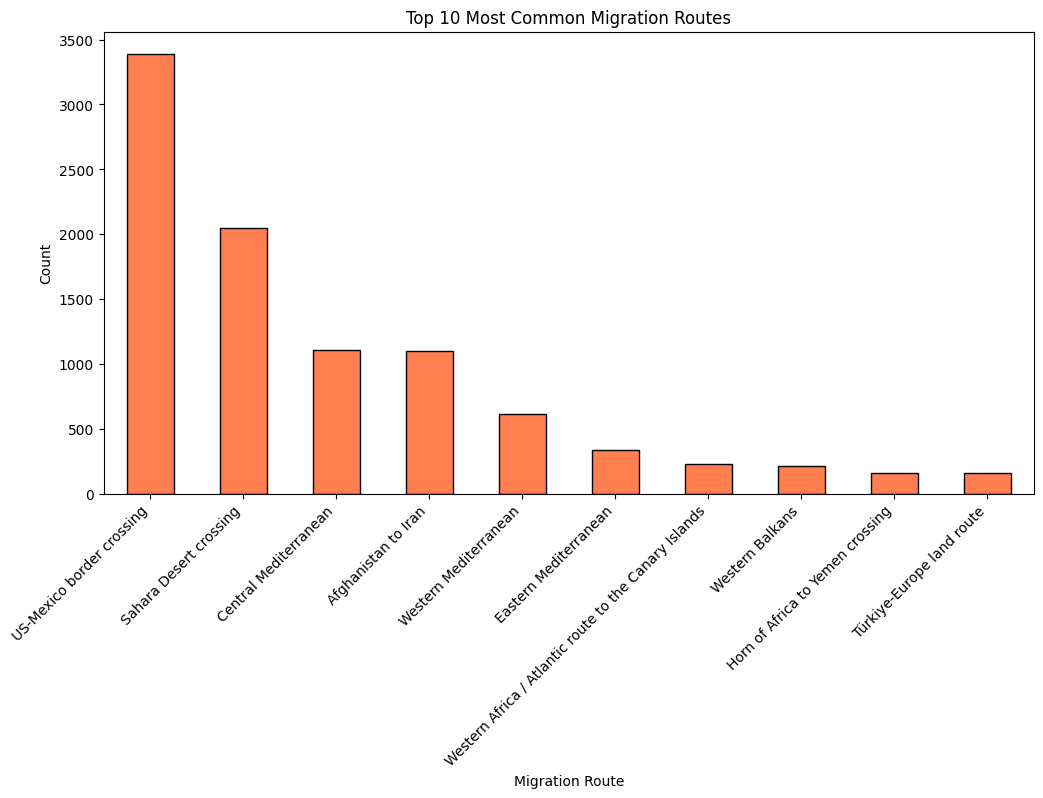

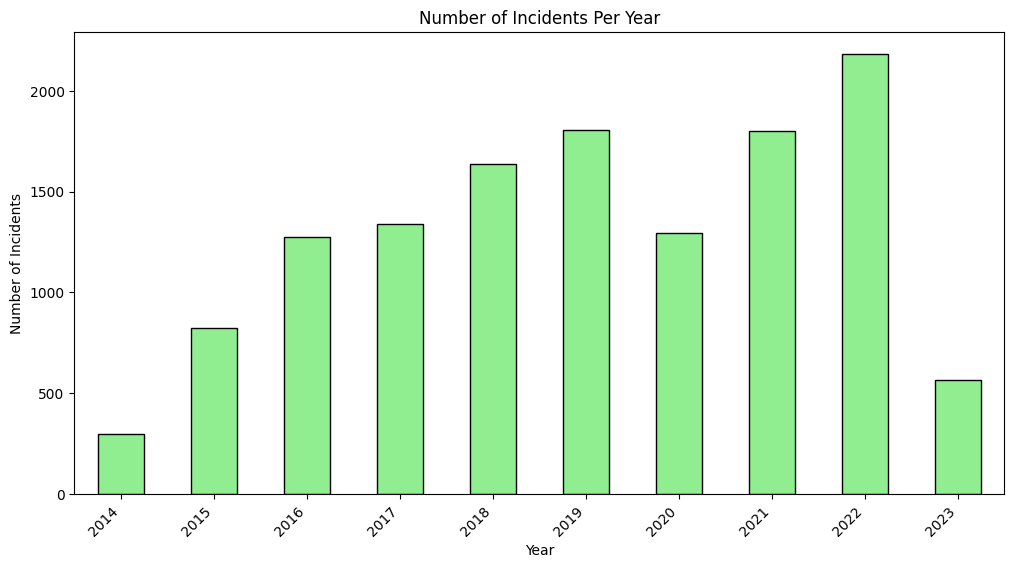

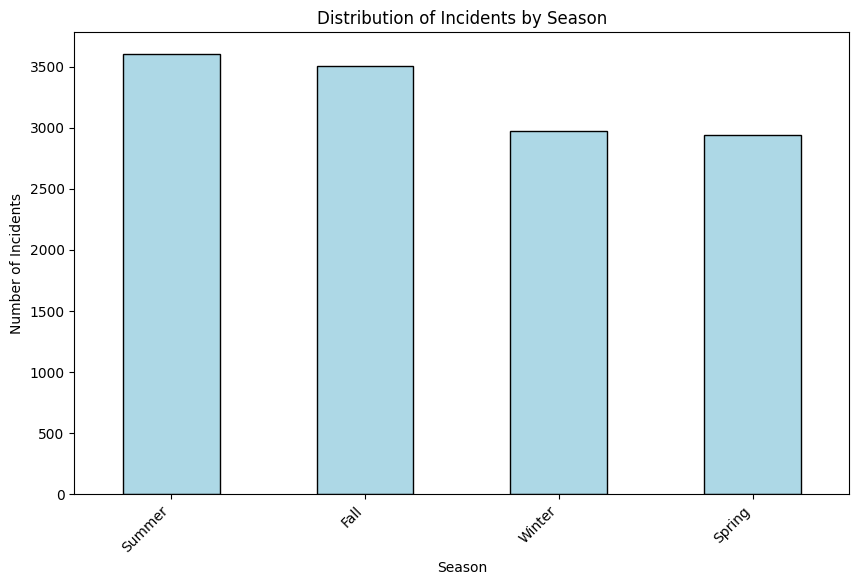

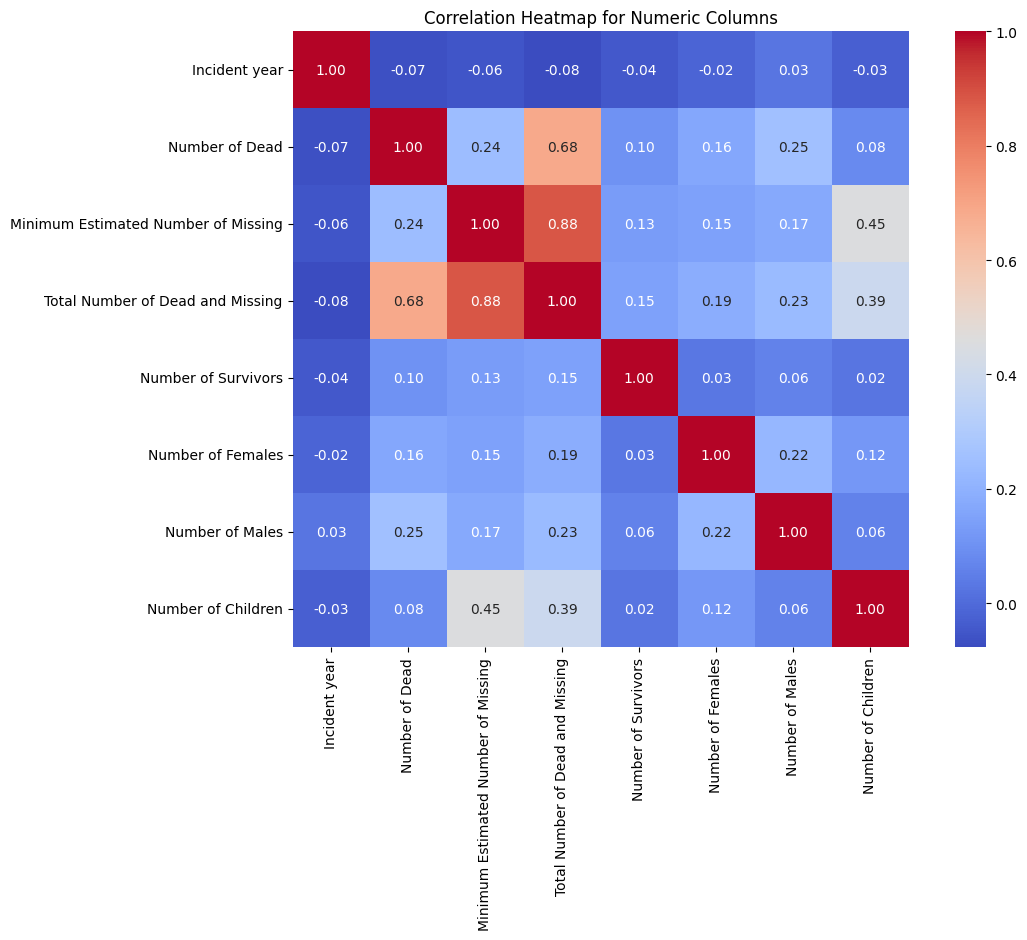

In [9]:



# Dataset Overview
print("Dataset Information:\n")
data.info()

print("\nMissing Values:\n")
print(data.isnull().sum())

print("\nBasic Statistics:\n")
print(data.describe())


# Most Common Migration Routes
plt.figure(figsize=(12, 6))
data['Migration route'].value_counts().head(10).plot(kind='bar', color='coral', edgecolor='black')
plt.title('Top 10 Most Common Migration Routes')
plt.xlabel('Migration Route')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Number of Incidents Per Year
plt.figure(figsize=(12, 6))
data['Incident year'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Number of Incidents Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.show()

# Seasonal Distribution of Incidents
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}
data['Season'] = data['Reported Month'].map(season_map)

plt.figure(figsize=(10, 6))
data['Season'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Distribution of Incidents by Season')
plt.xlabel('Season')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.show()

# Correlation Heatmap for Numeric Columns
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Generate the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap for Numeric Columns')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0972
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0465  
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0232 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310  
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0294 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0232  
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193  
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0287  
Epoch 16/50
7/7 ━━━━━━━━━━━━━━

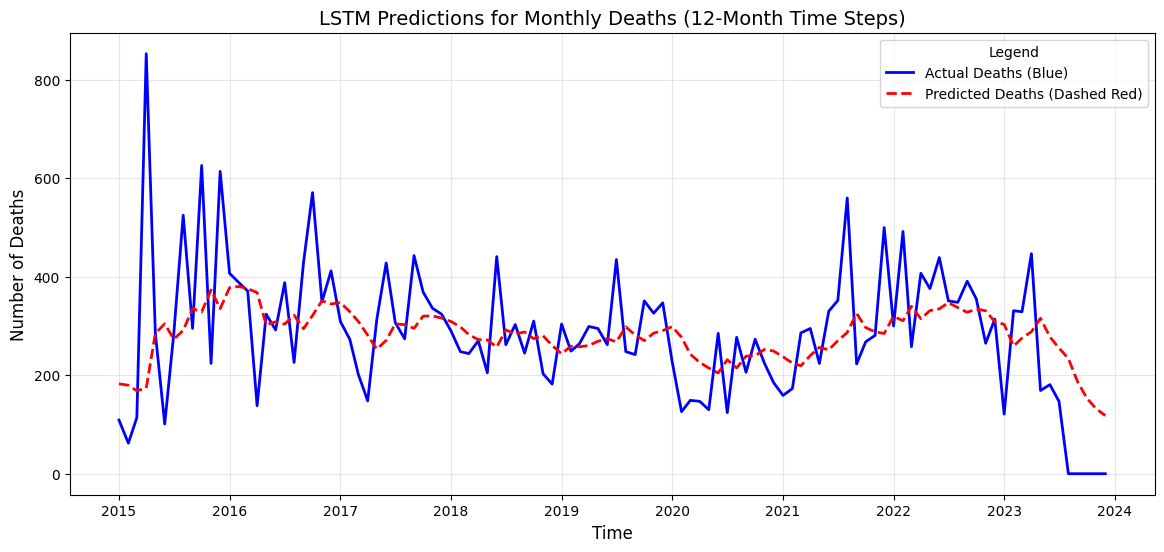

The season with the highest deaths is Summer with 8807.0 deaths.


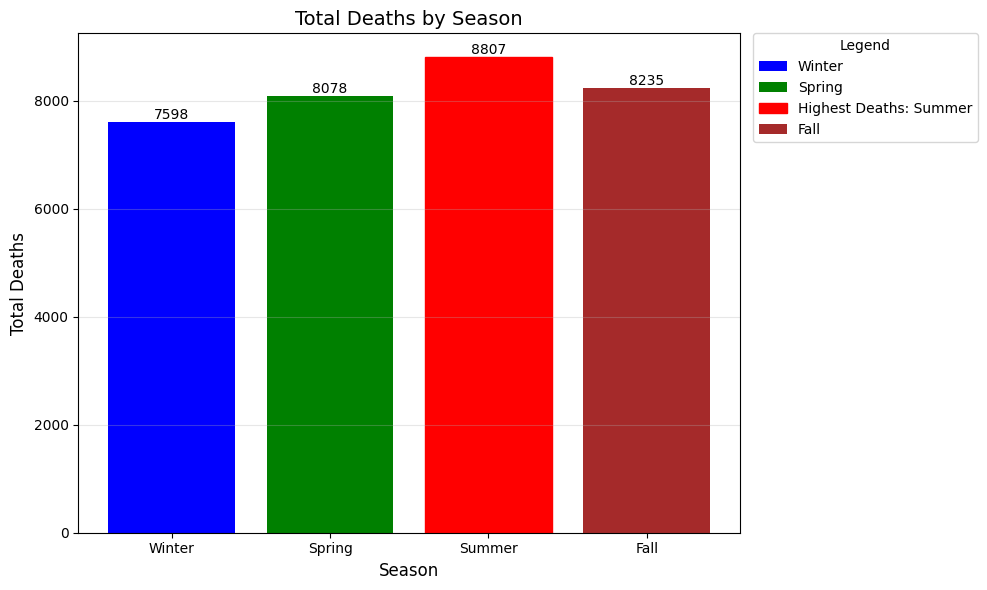

In [10]:


# Define season and month mappings
season_mapping = {
    1: "Winter", 2: "Winter", 3: "Spring",
    4: "Spring", 5: "Spring", 6: "Summer",
    7: "Summer", 8: "Summer", 9: "Fall",
    10: "Fall", 11: "Fall", 12: "Winter"
}
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5,
    "June": 6, "July": 7, "August": 8, "September": 9, "October": 10,
    "November": 11, "December": 12
}
data['Reported Month'] = data['Reported Month'].map(month_mapping)
data['Reported Month'] = pd.to_numeric(data['Reported Month'], errors='coerce')
data = data.dropna(subset=['Reported Month'])
data['Reported Month'] = data['Reported Month'].astype(int)
data['Season'] = data['Reported Month'].map(season_mapping)

# Group data by year and month
data['Year'] = pd.to_datetime(data['Incident year'], format='%Y').dt.year
monthly_deaths = data.groupby(['Year', 'Reported Month'])['Number of Dead'].sum().reset_index()
monthly_deaths = monthly_deaths.pivot(index='Year', columns='Reported Month', values='Number of Dead')
monthly_deaths = monthly_deaths.fillna(0).stack().reset_index()
monthly_deaths.columns = ['Year', 'Month', 'Number of Dead']

# Create a time-series index for plotting
monthly_deaths['Time'] = pd.to_datetime(monthly_deaths[['Year', 'Month']].assign(DAY=1))
monthly_deaths = monthly_deaths.sort_values('Time').reset_index(drop=True)

# Step 2: Prepare data for LSTM
time_steps = 12
scaler = MinMaxScaler()
scaled_deaths = scaler.fit_transform(monthly_deaths['Number of Dead'].values.reshape(-1, 1))

# Create sequences of 12 months for LSTM
def prepare_lstm_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = prepare_lstm_data(scaled_deaths, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM

# Step 3: Build and Train LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=50, verbose=1, batch_size=16)

# Step 4: Make Predictions
predictions = model.predict(X)
predictions_rescaled = scaler.inverse_transform(predictions)
y_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

# Step 5: Visualize Results
plt.figure(figsize=(14, 6))
plt.plot(monthly_deaths['Time'][time_steps:], y_rescaled, label='Actual Deaths (Blue)', color='blue', linewidth=2)
plt.plot(monthly_deaths['Time'][time_steps:], predictions_rescaled, label='Predicted Deaths (Dashed Red)', color='red', linestyle='dashed', linewidth=2)
plt.title("LSTM Predictions for Monthly Deaths (12-Month Time Steps)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Number of Deaths", fontsize=12)
plt.legend(title="Legend", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# Step 6: Seasonal Comparison and Identification of Highest Deaths
# Group by Season to calculate total deaths
seasonal_data = data.groupby('Season')['Number of Dead'].sum().reset_index()

# Ensure the season order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_data['Season'] = pd.Categorical(seasonal_data['Season'], categories=season_order, ordered=True)
seasonal_data = seasonal_data.sort_values('Season')

# Identify the season with the highest deaths
highest_deaths_season = seasonal_data.loc[seasonal_data['Number of Dead'].idxmax()]
print(f"The season with the highest deaths is {highest_deaths_season['Season']} with {highest_deaths_season['Number of Dead']} deaths.")

# Plot total deaths by season
plt.figure(figsize=(10, 6))
bars = plt.bar(
    seasonal_data['Season'],
    seasonal_data['Number of Dead'],
    color=['blue', 'green', 'orange', 'brown'],
    label=["Winter", "Spring", "Summer", "Fall"]
)

# Add labels for each bar
for bar, death_count in zip(bars, seasonal_data['Number of Dead']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{int(death_count)}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Highlight the season with the highest deaths
highest_season_index = season_order.index(highest_deaths_season['Season'])
bars[highest_season_index].set_color('red')
bars[highest_season_index].set_label(f"Highest Deaths: {highest_deaths_season['Season']}")

# Update legend to be placed outside the box
plt.legend(
    title="Legend", fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0
)
plt.title("Total Deaths by Season", fontsize=14)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Total Deaths", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Top 3 Migration Routes by Fatalities: ['Central Mediterranean' 'Sahara Desert crossing'
 'US-Mexico border crossing']
Analyzing route: Central Mediterranean
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - loss: 0.0787 - val_loss: 0.0516
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0912 - val_loss: 0.0437
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0722 - val_loss: 0.0362
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0806 - val_loss: 0.0298
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0598 - val_loss: 0.0254
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0585 - val_loss: 0.0235
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0446 - val_loss: 0.0239
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0495 - val_loss: 0.0257
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0526 - val_loss: 0.0271
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0491 - val_loss: 0.0269
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0565 - val_loss: 0.0257
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0544 - val_loss: 0.0243


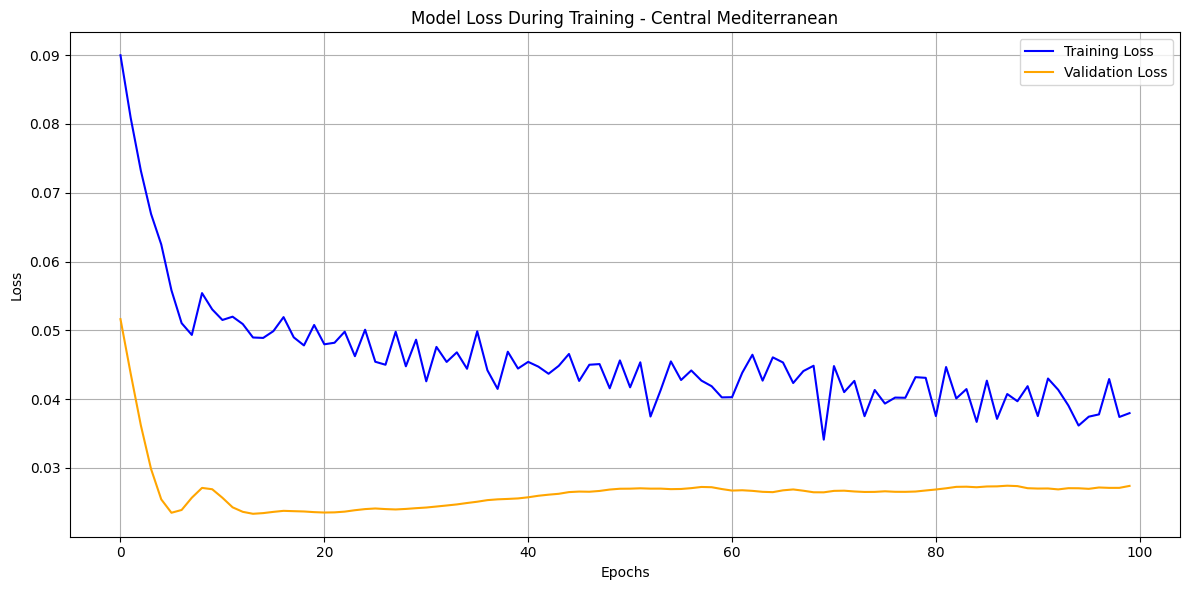

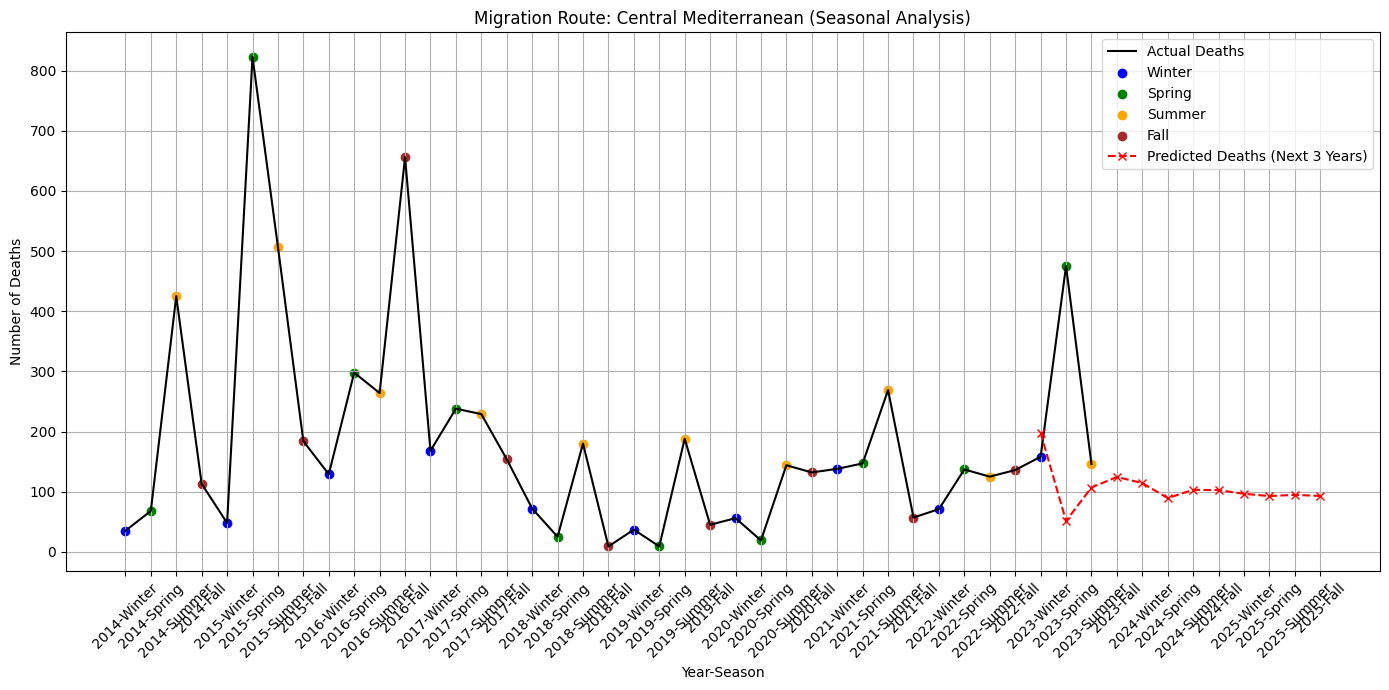

Analyzing route: Sahara Desert crossing
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - loss: 0.2363 - val_loss: 0.0053
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2215 - val_loss: 0.0033
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2051 - val_loss: 0.0024
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1793 - val_loss: 0.0027
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1774 - val_loss: 0.0046
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1356 - val_loss: 0.0086
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1128 - val_loss: 0.0156
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1003 - val_loss: 0.0268
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1033 - val_loss: 0.0439
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0783 - val_loss: 0.0684
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0718 - val_loss: 0.0972
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0690 - val_loss: 0.1240


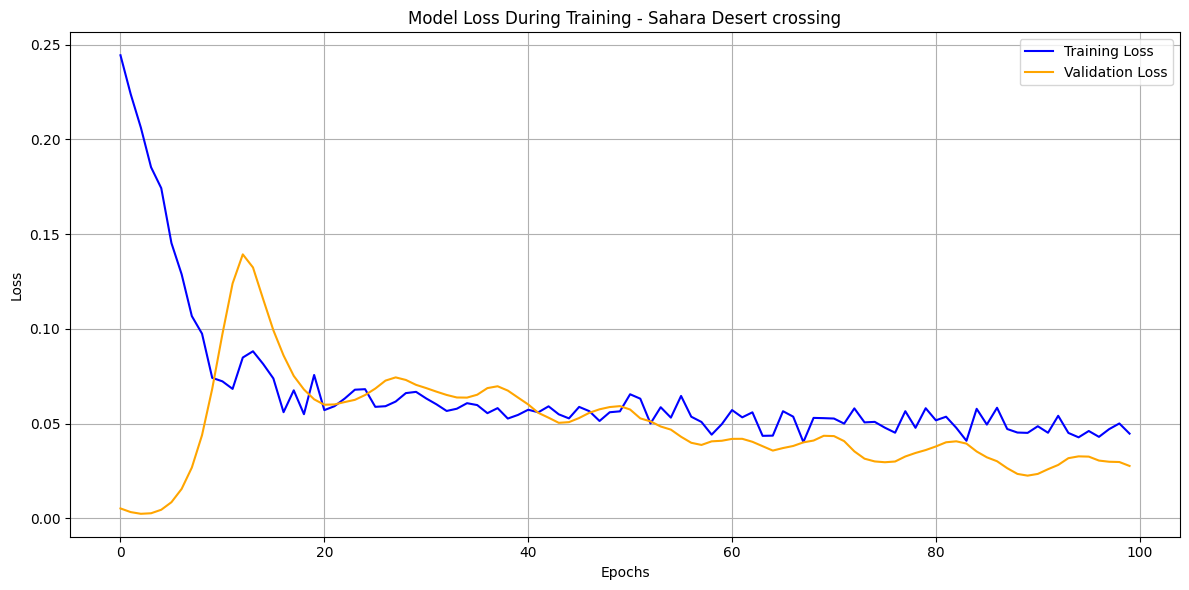

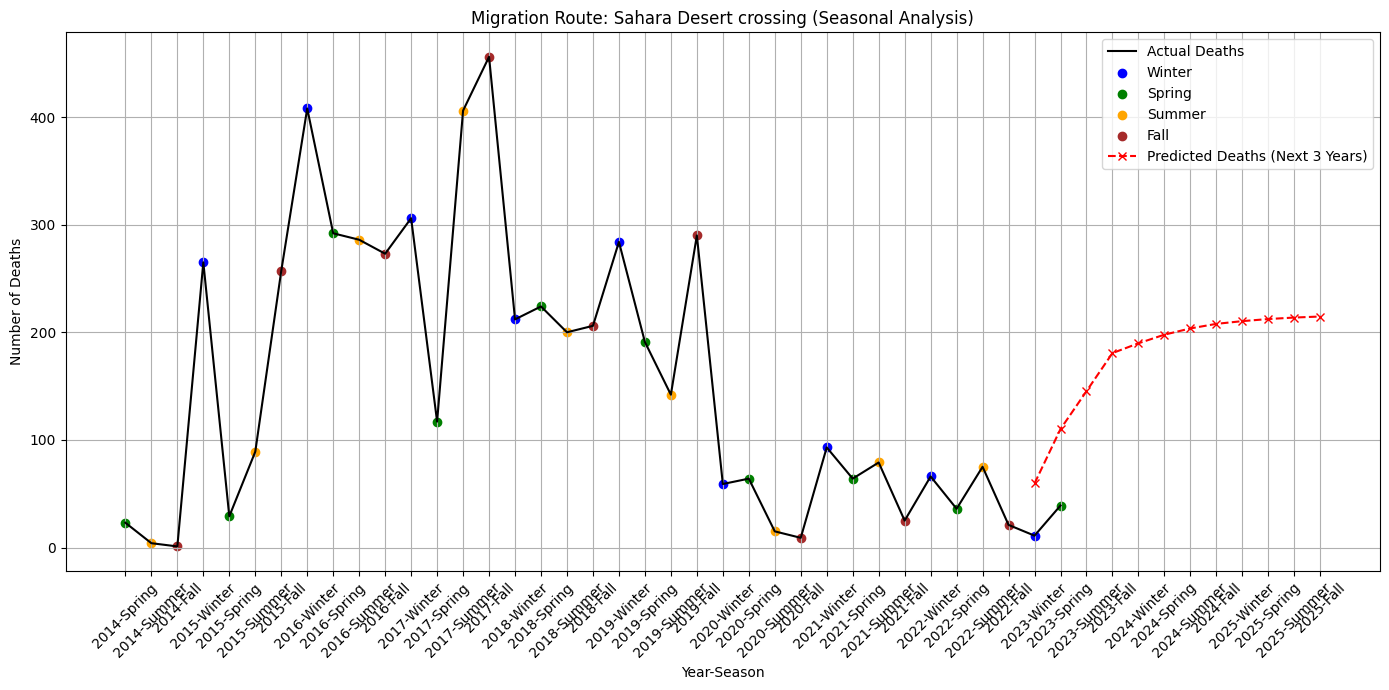

Analyzing route: US-Mexico border crossing
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - loss: 0.1648 - val_loss: 0.2424
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1628 - val_loss: 0.2190
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1413 - val_loss: 0.1971
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1212 - val_loss: 0.1769
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0981 - val_loss: 0.1573
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0933 - val_loss: 0.1376
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0900 - val_loss: 0.1186
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0620 - val_loss: 0.1015
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0531 - val_loss: 0.0884
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0448 - val_loss: 0.0818
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0367 - val_loss: 0.0826
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0448 - val_loss: 0.0854


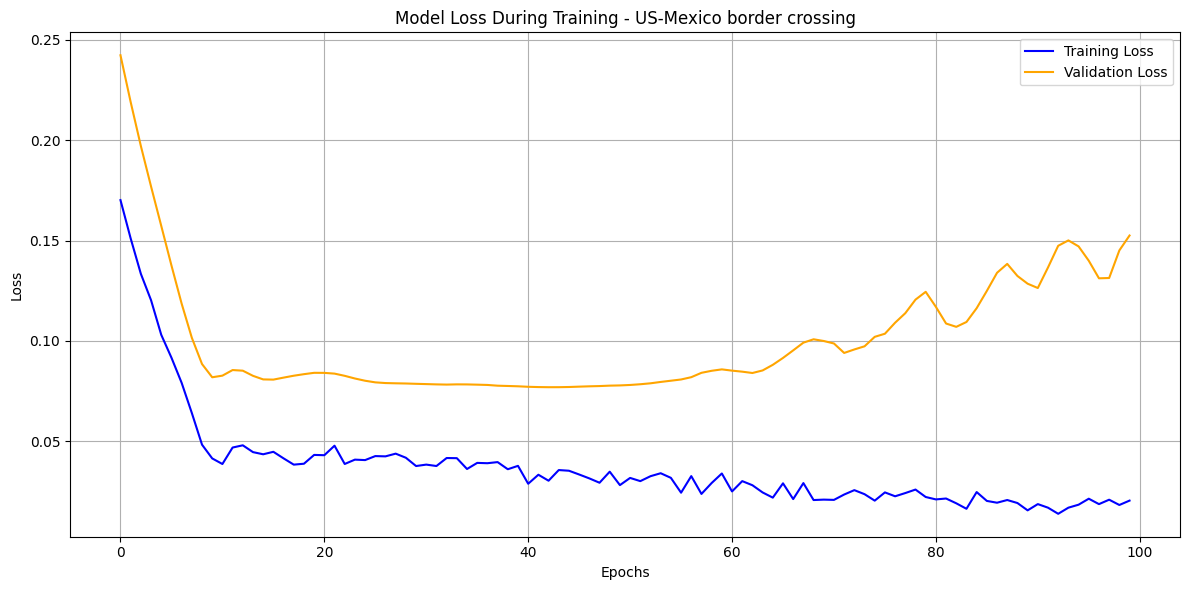

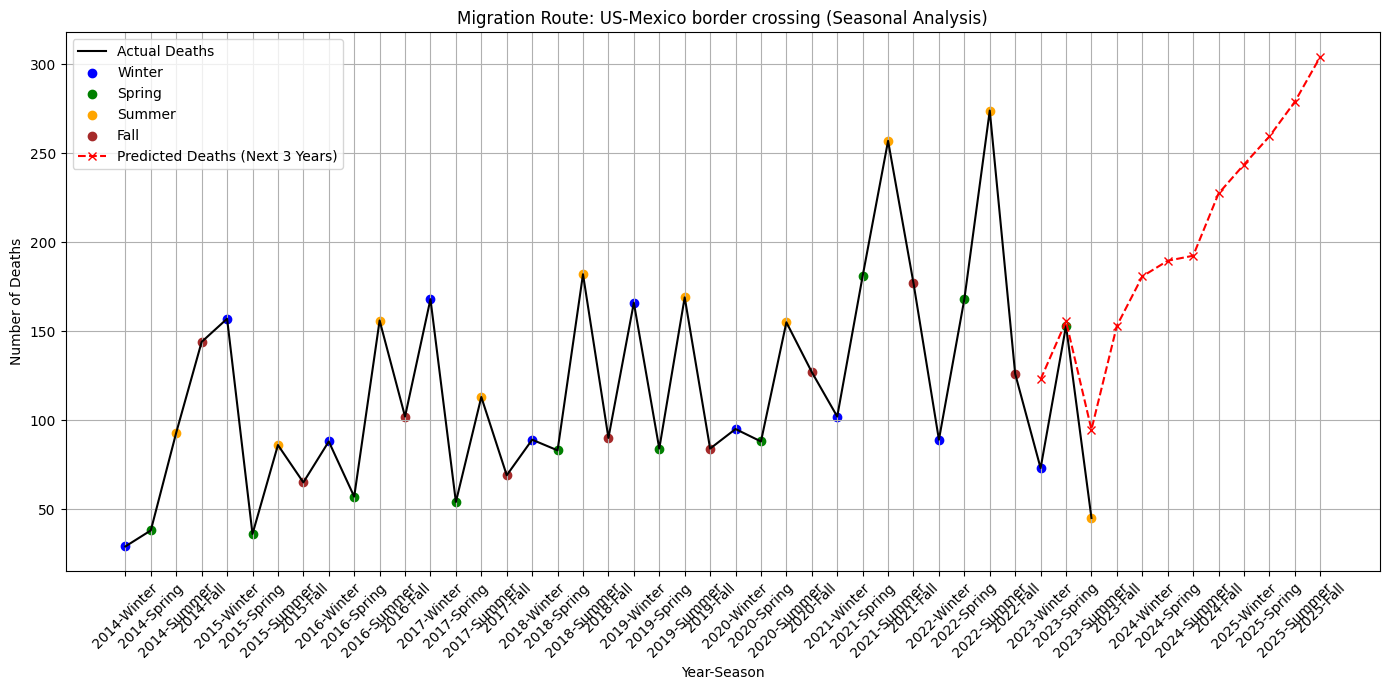

In [15]:

# Calculate total deaths by migration route
route_totals = data.groupby('Migration route')['Number of Dead'].sum().reset_index()
route_totals = route_totals.sort_values(by='Number of Dead', ascending=False).dropna()
top_routes = route_totals.head(3)['Migration route'].values

print(f"Top 3 Migration Routes by Fatalities: {top_routes}")

# Define the season mapping
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

data['Season'] = data['Reported Month'].map(season_map)

# Loop through the top 3 migration routes
for specific_route in top_routes:
    print(f"Analyzing route: {specific_route}")
    route_data = data[data['Migration route'] == specific_route].copy()

    if route_data.shape[0] < 4:
        print(f"Not enough data for the migration route: {specific_route}")
        continue

    # Create a 'Year-Season' column
    route_data['Year-Season'] = route_data['Incident year'].astype(str) + '-' + route_data['Season']
    seasonal_data = route_data.groupby('Year-Season')['Number of Dead'].sum().reset_index()

    # Extract year and season
    seasonal_data['Year'] = seasonal_data['Year-Season'].str.split('-').str[0].astype(int)
    seasonal_data['Season'] = seasonal_data['Year-Season'].str.split('-').str[1]
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    seasonal_data['Season'] = pd.Categorical(seasonal_data['Season'], categories=season_order, ordered=True)
    seasonal_data = seasonal_data.sort_values(by=['Year', 'Season']).reset_index(drop=True)

    # Add sine and cosine encoding for seasonality
    seasonal_data['Month'] = seasonal_data['Season'].map({'Winter': 1, 'Spring': 4, 'Summer': 7, 'Fall': 10}).astype(int)
    seasonal_data['Normalized_Month'] = seasonal_data['Month'] / 12.0
    seasonal_data['sin_month'] = np.sin(2 * np.pi * seasonal_data['Normalized_Month'])
    seasonal_data['cos_month'] = np.cos(2 * np.pi * seasonal_data['Normalized_Month'])

    # Prepare data for LSTM
    deaths = seasonal_data['Number of Dead'].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    deaths_scaled = scaler.fit_transform(deaths.reshape(-1, 1))

    # Create time-series data
    time_steps = 4
    X, y = [], []
    for i in range(len(deaths_scaled) - time_steps):
        features = np.column_stack((
            deaths_scaled[i:i + time_steps],
            seasonal_data['sin_month'].iloc[i:i + time_steps].values,
            seasonal_data['cos_month'].iloc[i:i + time_steps].values
        ))
        X.append(features)
        y.append(deaths_scaled[i + time_steps])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train LSTM model
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, X.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_test, y_test))

    # Evaluate the model
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    r2 = r2_score(y_test_actual, y_pred)

    print(f"Route: {specific_route}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R\u00b2 Score: {r2}")

    # Visualize training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Model Loss During Training - {specific_route}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Predict future deaths
    last_sequence = np.column_stack((
        deaths_scaled[-time_steps:],
        seasonal_data['sin_month'].iloc[-time_steps:].values,
        seasonal_data['cos_month'].iloc[-time_steps:].values
    ))
    predictions = []
    for _ in range(12):  # Predict next 3 years
        last_sequence_reshaped = np.expand_dims(last_sequence, axis=0)
        next_pred = model.predict(last_sequence_reshaped, verbose=0)
        predictions.append(next_pred[0, 0])
        new_feature = np.array([next_pred[0, 0], last_sequence[-1, 1], last_sequence[-1, 2]])
        last_sequence = np.vstack((last_sequence[1:], new_feature))
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Visualize results
    colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Fall': 'brown'}
    plt.figure(figsize=(14, 7))

    # Plot actual deaths as a line
    plt.plot(seasonal_data['Year-Season'], deaths, label='Actual Deaths', color='black', linestyle='-')

    # Add color-coded dots for each season
    for season, color in colors.items():
        season_data = seasonal_data[seasonal_data['Season'] == season]
        plt.scatter(season_data['Year-Season'], season_data['Number of Dead'], color=color, label=season)

    # Plot predicted deaths as a dashed line
    last_year = seasonal_data['Year'].iloc[-1]
    future_seasons = [(last_year + (i // 4), season_order[i % 4]) for i in range(12)]
    future_labels = [f"{year}-{season}" for year, season in future_seasons]
    plt.plot(future_labels, predictions, label='Predicted Deaths (Next 3 Years)', marker='x', linestyle='--', color='red')

    # Add labels and title
    plt.xlabel("Year-Season")
    plt.ylabel("Number of Deaths")
    plt.title(f"Migration Route: {specific_route} (Seasonal Analysis)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Top 3 Migration Routes by Fatalities: ['Central Mediterranean' 'Sahara Desert crossing'
 'US-Mexico border crossing']
Analyzing route: Central Mediterranean
Random Forest Metrics for Central Mediterranean:
  MAE: 84.88142857142863, RMSE: 142.93175539396418


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


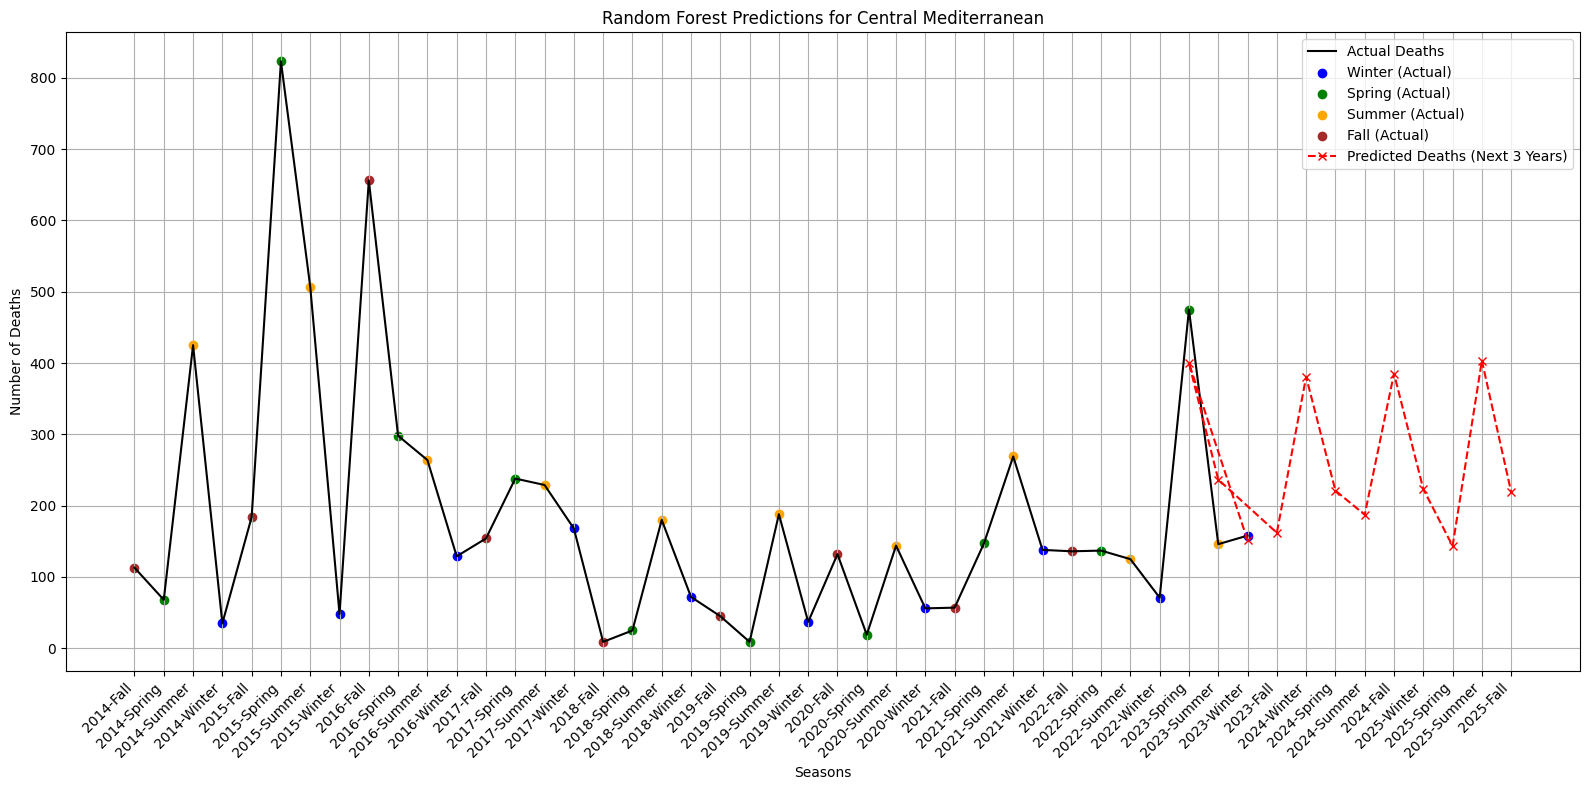

Analyzing route: Sahara Desert crossing
Random Forest Metrics for Sahara Desert crossing:
  MAE: 49.957142857142806, RMSE: 65.20693828113689


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


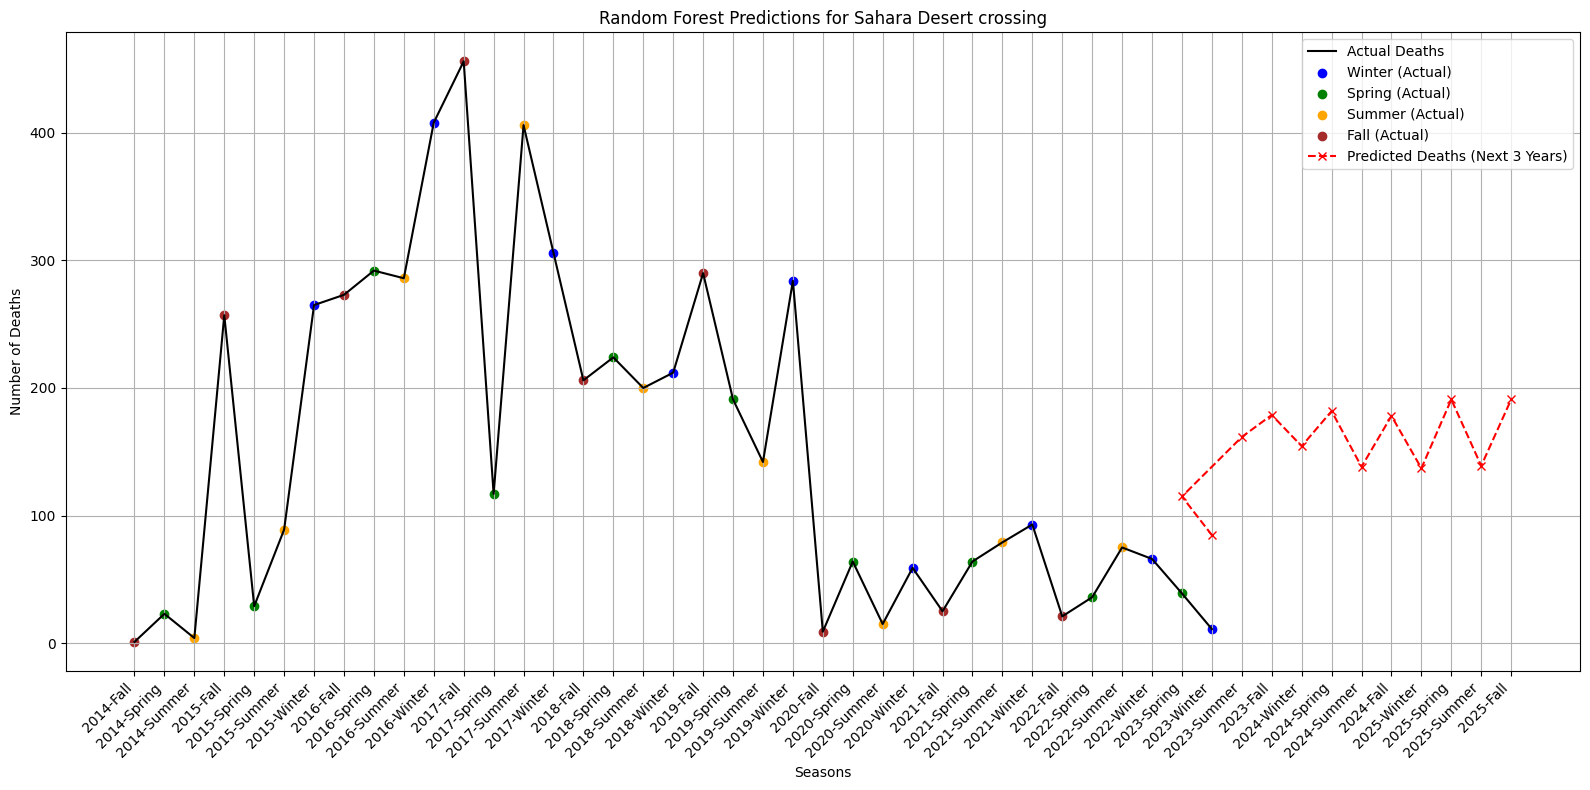

Analyzing route: US-Mexico border crossing
Random Forest Metrics for US-Mexico border crossing:
  MAE: 54.5757142857143, RMSE: 66.80592157243892


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


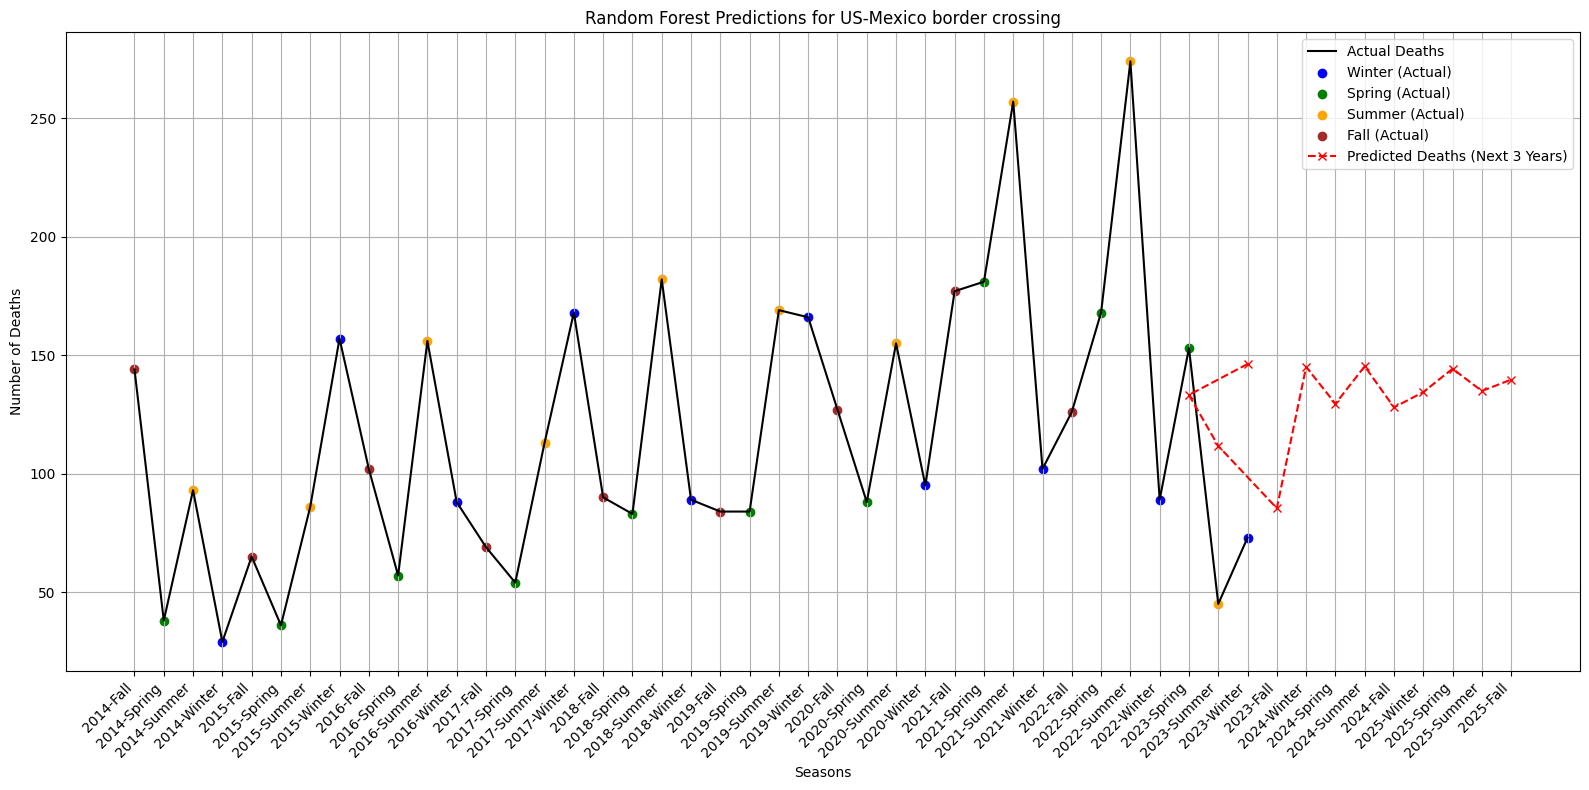

In [16]:

# Step 2: Calculate total deaths by migration route
route_totals = data.groupby('Migration route')['Number of Dead'].sum().reset_index()
route_totals = route_totals.sort_values(by='Number of Dead', ascending=False).dropna()
top_routes = route_totals.head(3)['Migration route'].values
print(f"Top 3 Migration Routes by Fatalities: {top_routes}")

# Map months to seasons
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

season_colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Fall': 'brown'}

# Loop through the top 3 migration routes
for specific_route in top_routes:
    print(f"Analyzing route: {specific_route}")
    route_data = data[data['Migration route'] == specific_route].copy()

    if route_data.shape[0] < 12:
        print(f"Not enough data for the migration route: {specific_route}")
        continue

    # Add a 'Season' column
    route_data['Season'] = route_data['Reported Month'].map(season_map)

    # Aggregate deaths by season and year
    route_data['Year'] = route_data['Incident year']
    route_data['Year-Season'] = route_data['Year'].astype(str) + '-' + route_data['Season']
    seasonal_data = route_data.groupby(['Year-Season', 'Season', 'Year'])['Number of Dead'].sum().reset_index()

    # Prepare data for modeling
    deaths = seasonal_data['Number of Dead'].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    deaths_scaled = scaler.fit_transform(deaths.reshape(-1, 1))

    time_steps = 4
    X, y = [], []
    for i in range(len(deaths_scaled) - time_steps):
        X.append(deaths_scaled[i:i + time_steps].flatten())
        y.append(deaths_scaled[i + time_steps])

    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate model
    rf_predictions = rf_model.predict(X_test)
    rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    rf_mae = mean_absolute_error(y_test_actual, rf_predictions)
    rf_rmse = np.sqrt(mean_squared_error(y_test_actual, rf_predictions))
    print(f"Random Forest Metrics for {specific_route}:\n  MAE: {rf_mae}, RMSE: {rf_rmse}")

    # Extend predictions for the next 3 years (12 seasons)
    extended_rf_predictions = []
    last_sequence = X[-1]
    for _ in range(12):  # Predict next 3 years
        rf_next_pred = rf_model.predict(last_sequence.reshape(1, -1))
        extended_rf_predictions.append(rf_next_pred[0])
        last_sequence = np.append(last_sequence[1:], rf_next_pred).flatten()
    extended_rf_predictions = scaler.inverse_transform(np.array(extended_rf_predictions).reshape(-1, 1))

    # Create future seasons starting after the last Year-Season in actual data
    last_year = seasonal_data['Year'].iloc[-1]
    last_season = seasonal_data['Season'].iloc[-1]
    season_index = list(season_colors.keys()).index(last_season)
    future_seasons = []
    for i in range(12):
        year = last_year + (season_index + i) // 4
        season = list(season_colors.keys())[(season_index + i) % 4]
        future_seasons.append(f"{year}-{season}")

    # Visualize results
    plt.figure(figsize=(16, 8))
    plt.plot(seasonal_data['Year-Season'], deaths, label='Actual Deaths', color='black', linestyle='-')

    # Add color-coded dots for seasons
    for season, color in season_colors.items():
        seasonal_subset = seasonal_data[seasonal_data['Season'] == season]
        plt.scatter(seasonal_subset['Year-Season'], seasonal_subset['Number of Dead'], color=color, label=f'{season} (Actual)')

    # Plot predictions
    plt.plot(future_seasons, extended_rf_predictions, label='Predicted Deaths (Next 3 Years)', marker='x', linestyle='--', color='red')

    # Add labels, title, and legend
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Seasons")
    plt.ylabel("Number of Deaths")
    plt.title(f"Random Forest Predictions for {specific_route}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Top 3 Migration Routes by Fatalities: ['Central Mediterranean' 'Sahara Desert crossing'
 'US-Mexico border crossing']
Analyzing route: Central Mediterranean
XGBoost Metrics for Central Mediterranean:
  MAE: 95.6382669721331, RMSE: 131.6721292558474


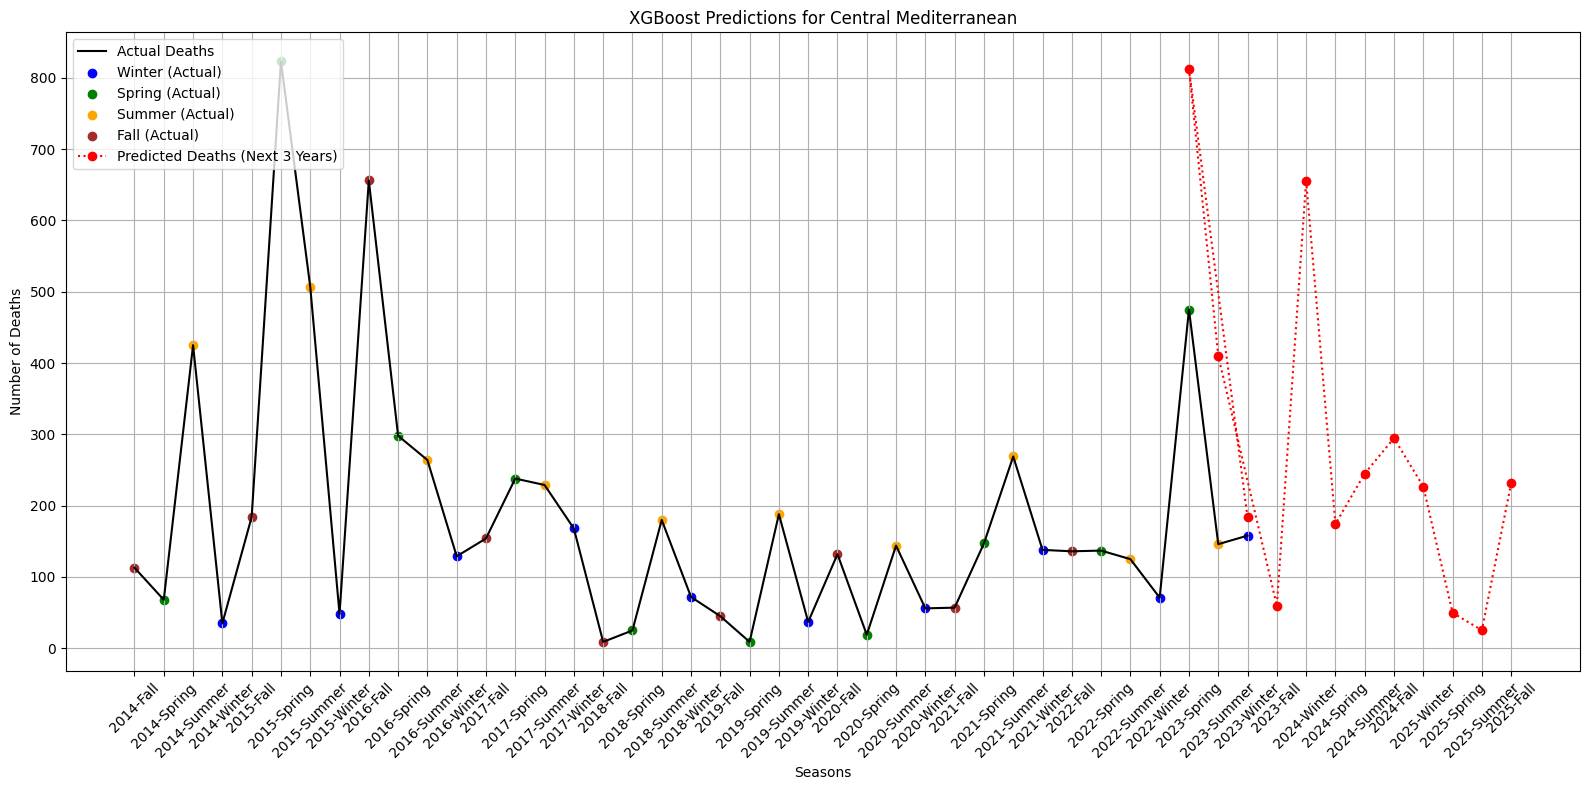

Analyzing route: Sahara Desert crossing
XGBoost Metrics for Sahara Desert crossing:
  MAE: 66.05799402509417, RMSE: 86.40559164843604


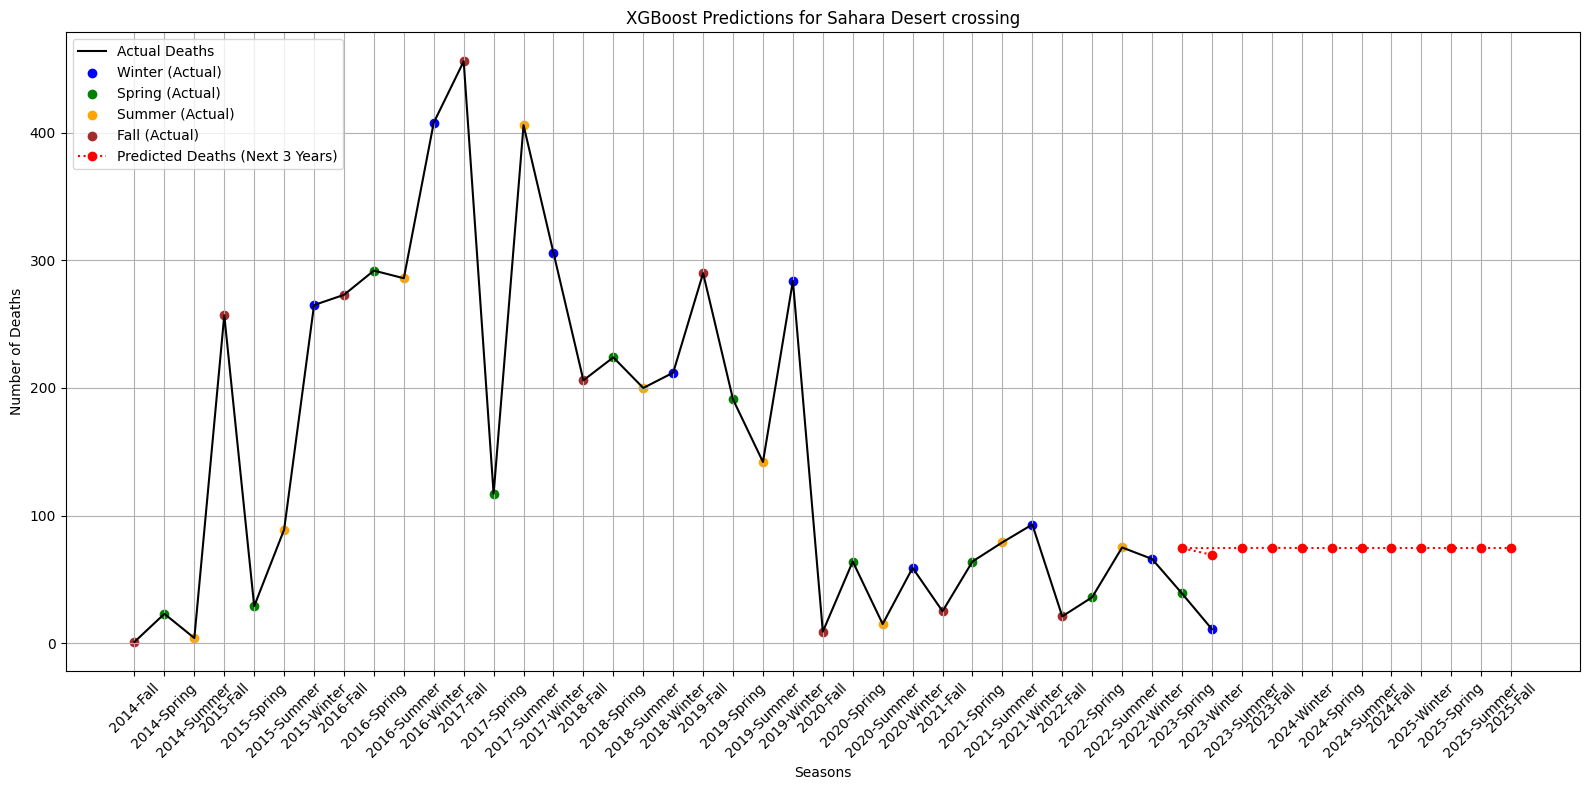

Analyzing route: US-Mexico border crossing
XGBoost Metrics for US-Mexico border crossing:
  MAE: 57.991050720214844, RMSE: 70.18482579458527


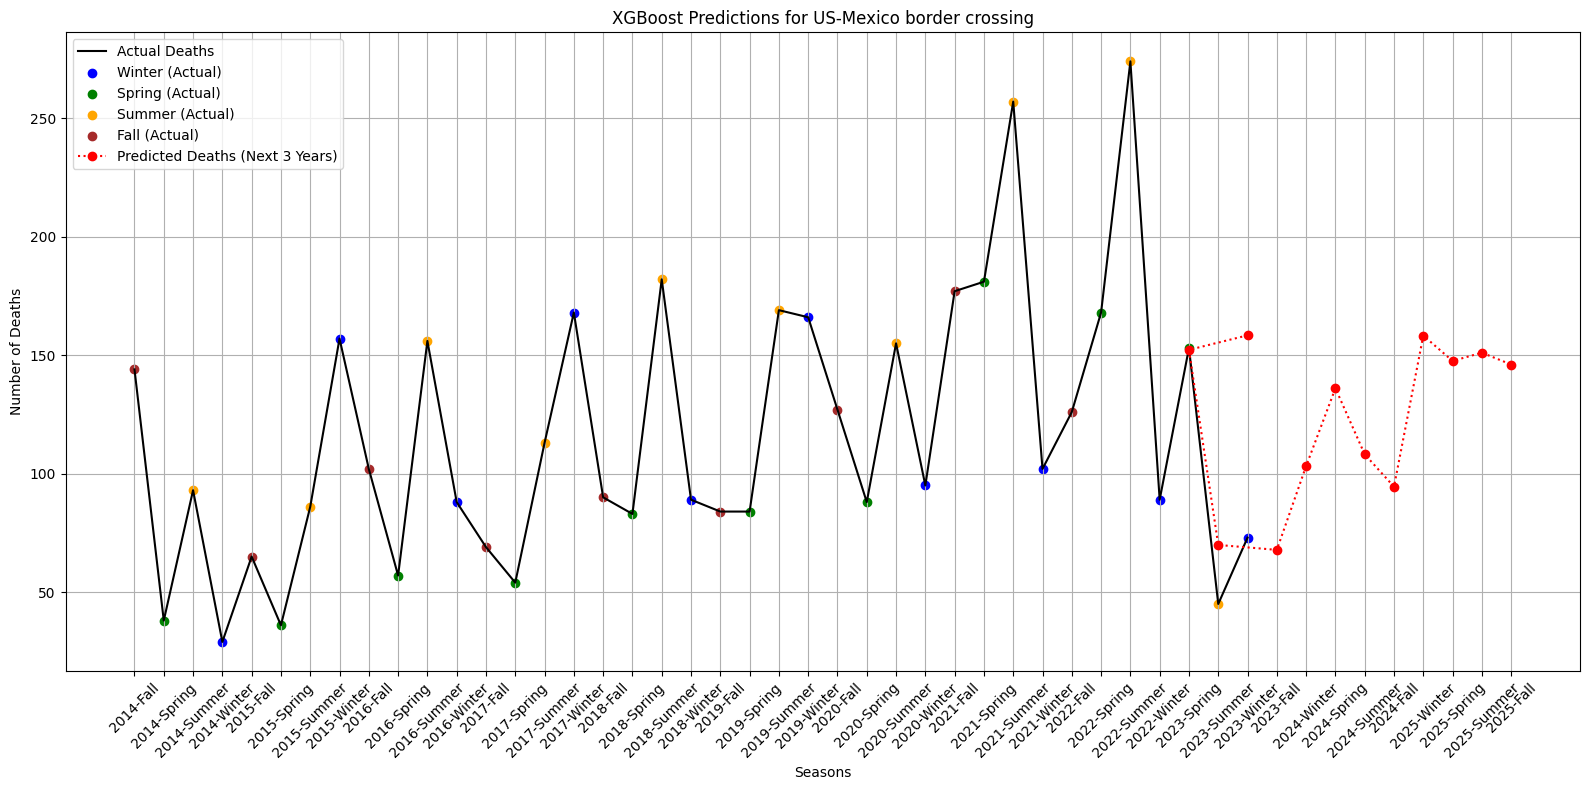

In [17]:


# Calculate total deaths by migration route
route_totals = data.groupby('Migration route')['Number of Dead'].sum().reset_index()
route_totals = route_totals.sort_values(by='Number of Dead', ascending=False).dropna()
top_routes = route_totals.head(3)['Migration route'].values
print(f"Top 3 Migration Routes by Fatalities: {top_routes}")

# Map months to seasons
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

season_colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Fall': 'brown'}

# Loop through the top 3 migration routes
for specific_route in top_routes:
    print(f"Analyzing route: {specific_route}")
    route_data = data[data['Migration route'] == specific_route].copy()

    if route_data.shape[0] < 12:
        print(f"Not enough data for the migration route: {specific_route}")
        continue

    # Add a 'Season' column
    route_data['Season'] = route_data['Reported Month'].map(season_map)

    # Aggregate deaths by season and year
    route_data['Year'] = route_data['Incident year']
    route_data['Year-Season'] = route_data['Year'].astype(str) + '-' + route_data['Season']
    seasonal_data = route_data.groupby(['Year-Season', 'Season', 'Year'])['Number of Dead'].sum().reset_index()

    # Prepare data for modeling
    deaths = seasonal_data['Number of Dead'].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    deaths_scaled = scaler.fit_transform(deaths.reshape(-1, 1))

    time_steps = 4
    X, y = [], []
    for i in range(len(deaths_scaled) - time_steps):
        X.append(deaths_scaled[i:i + time_steps].flatten())
        y.append(deaths_scaled[i + time_steps])

    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Evaluate model
    xgb_predictions = xgb_model.predict(X_test)
    xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    xgb_mae = mean_absolute_error(y_test_actual, xgb_predictions)
    xgb_rmse = np.sqrt(mean_squared_error(y_test_actual, xgb_predictions))
    print(f"XGBoost Metrics for {specific_route}:\n  MAE: {xgb_mae}, RMSE: {xgb_rmse}")

    # Extend predictions for the next 3 years (12 seasons)
    extended_xgb_predictions = []
    last_sequence = X[-1]
    for _ in range(12):  # Predict next 3 years
        xgb_next_pred = xgb_model.predict(last_sequence.reshape(1, -1))
        extended_xgb_predictions.append(xgb_next_pred[0])
        last_sequence = np.append(last_sequence[1:], xgb_next_pred).flatten()
    extended_xgb_predictions = scaler.inverse_transform(np.array(extended_xgb_predictions).reshape(-1, 1))

    # Create future seasons
    last_year = seasonal_data['Year'].iloc[-1]
    future_seasons = [f"{last_year + (i // 4)}-{list(season_colors.keys())[i % 4]}" for i in range(12)]

    # Visualize results
    plt.figure(figsize=(16, 8))
    plt.plot(seasonal_data['Year-Season'], deaths, label='Actual Deaths', color='black', linestyle='-')

    # Add color-coded dots for seasons
    for season, color in season_colors.items():
        seasonal_subset = seasonal_data[seasonal_data['Season'] == season]
        plt.scatter(seasonal_subset['Year-Season'], seasonal_subset['Number of Dead'], color=color, label=f'{season} (Actual)')

    # Plot predictions
    plt.plot(future_seasons, extended_xgb_predictions, label='Predicted Deaths (Next 3 Years)', marker='o', linestyle='dotted', color='red')

    # Add labels, title, and legend
    plt.xticks(rotation=45, ha='center')  # Centered and rotated
    plt.xlabel("Seasons")
    plt.ylabel("Number of Deaths")
    plt.title(f"XGBoost Predictions for {specific_route}")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()


Analyzing route: Route A


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Analyzing route: Route B


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Analyzing route: Route C


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Model Comparison Results:
     Route          Model       MAE      RMSE        R²
0  Route A  Random Forest  0.199460  0.260993  0.830613
1  Route A        XGBoost  0.166007  0.246811  0.848522
2  Route A           LSTM  0.330315  0.375206  0.649926
3  Route B  Random Forest  0.155015  0.196844  0.908785
4  Route B        XGBoost  0.197565  0.273019  0.824527
5  Route B           LSTM  0.274793  0.311241  0.771956
6  Route C  Random Forest  0.124466  0.162139  0.933236
7  Route C        XGBoost  0.172963  0.240012  0.853705
8  Route C           LSTM  0.283810  0.321788  0.737031


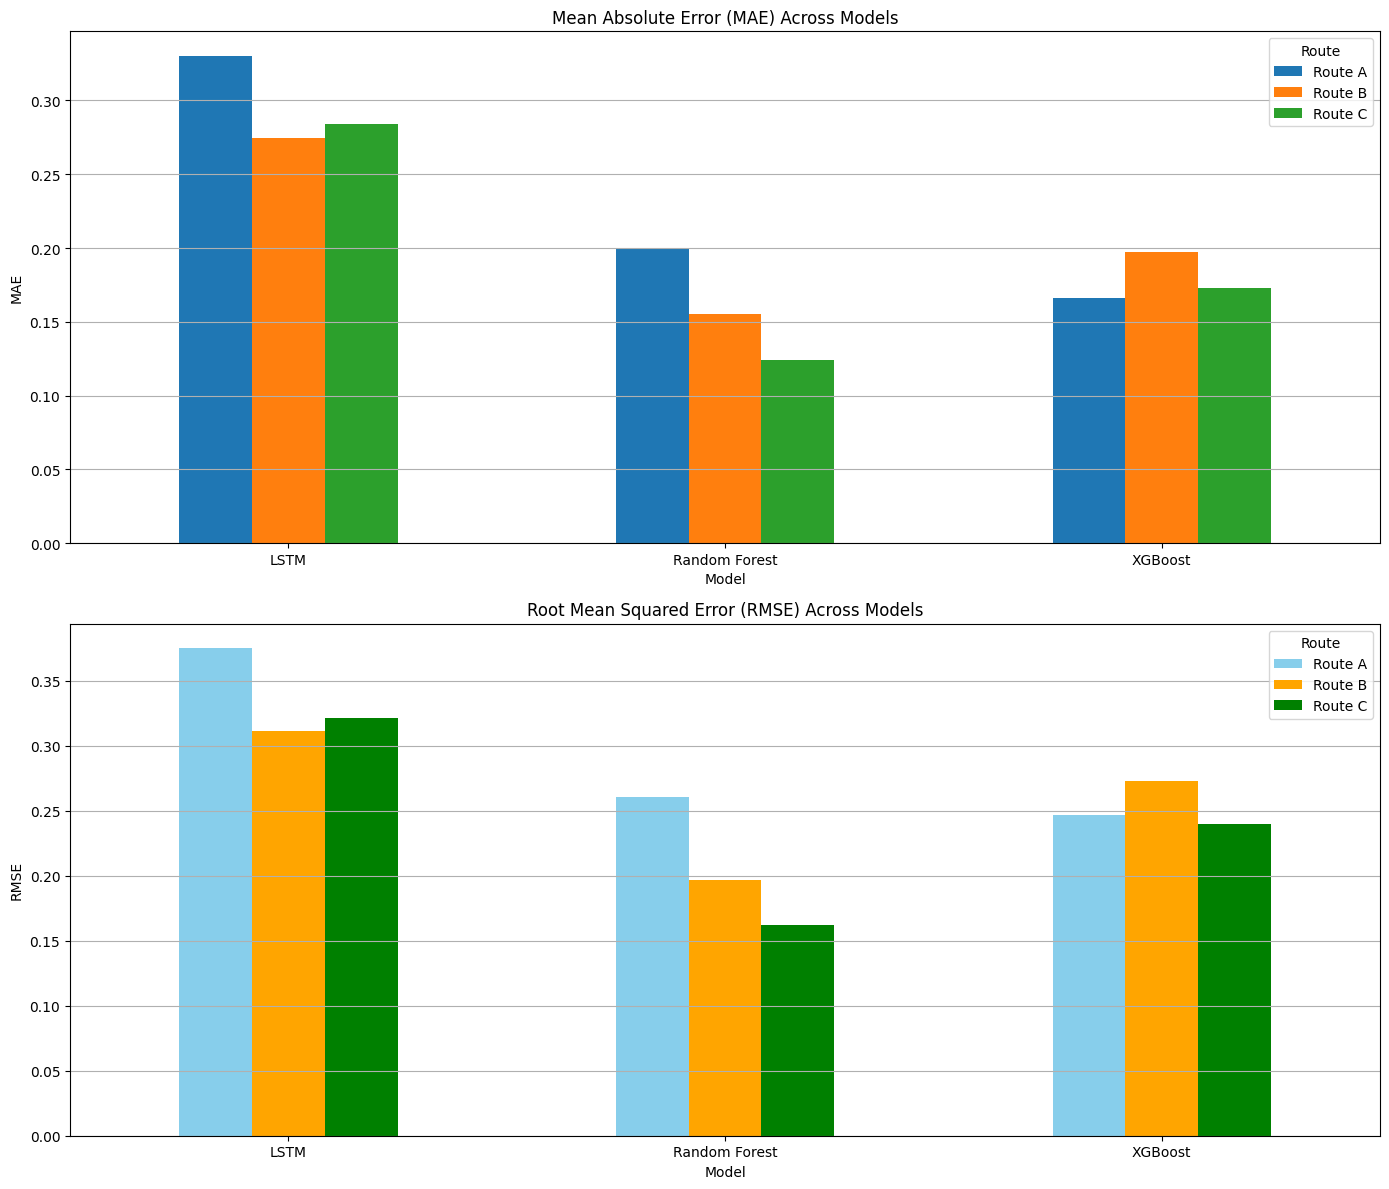

Best Models for Each Route:
     Route          Model       MAE      RMSE        R²
1  Route A        XGBoost  0.166007  0.246811  0.848522
3  Route B  Random Forest  0.155015  0.196844  0.908785
6  Route C  Random Forest  0.124466  0.162139  0.933236


In [18]:

# Initialize results dictionary
results = []

# Function to train and evaluate models
def train_evaluate_model(route_name, model_name, model, X_train, y_train, X_test, y_test, scaler):
    # Train the model
    if model_name == "LSTM":
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    else:
        model.fit(X_train, y_train)

    # Predictions
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled if model_name == "LSTM" else y_pred_scaled.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    mae = mean_absolute_error(y_test_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    r2 = r2_score(y_test_actual, y_pred)

    # Store results
    results.append({
        "Route": route_name,
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Example top 3 routes
# Replace this list with the actual top routes identified from your dataset
top_routes = ["Route A", "Route B", "Route C"]

# Simulated dataset for each route (replace with actual data preprocessing logic)
for specific_route in top_routes:
    print(f"Analyzing route: {specific_route}")

    # Simulated preprocessing
    data_length = 100
    deaths = np.sin(np.linspace(0, 20, data_length)) + np.random.normal(scale=0.1, size=data_length)

    # Scaling data
    scaler = MinMaxScaler()
    deaths_scaled = scaler.fit_transform(deaths.reshape(-1, 1))

    # Create time-series data
    time_steps = 4
    X, y = [], []
    for i in range(len(deaths_scaled) - time_steps):
        X.append(deaths_scaled[i:i + time_steps])
        y.append(deaths_scaled[i + time_steps])

    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    train_evaluate_model(specific_route, "Random Forest", rf_model, X_train.reshape(X_train.shape[0], -1), y_train, X_test.reshape(X_test.shape[0], -1), y_test, scaler)

    # XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    train_evaluate_model(specific_route, "XGBoost", xgb_model, X_train.reshape(X_train.shape[0], -1), y_train, X_test.reshape(X_test.shape[0], -1), y_test, scaler)

    # LSTM
    X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    lstm_model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    train_evaluate_model(specific_route, "LSTM", lstm_model, X_train_lstm, y_train, X_test_lstm, y_test, scaler)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("Model Comparison Results:")
print(results_df)

# Highlighting the best model for each route
best_models = results_df.loc[results_df.groupby("Route")['RMSE'].idxmin()]

# Plot results with Models on x-axis
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# MAE and RMSE bar plot
results_pivot_mae = results_df.pivot(index="Model", columns="Route", values="MAE")
results_pivot_mae.plot(kind="bar", ax=axes[0])
axes[0].set_title("Mean Absolute Error (MAE) Across Models")
axes[0].set_ylabel("MAE")
axes[0].set_xlabel("Model")
axes[0].grid(axis='y')
axes[0].tick_params(axis='x', rotation=0)

results_pivot_rmse = results_df.pivot(index="Model", columns="Route", values="RMSE")
results_pivot_rmse.plot(kind="bar", ax=axes[1], color=['skyblue', 'orange', 'green'])
axes[1].set_title("Root Mean Squared Error (RMSE) Across Models")
axes[1].set_ylabel("RMSE")
axes[1].set_xlabel("Model")
axes[1].grid(axis='y')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print best models
print("Best Models for Each Route:")
print(best_models)
